In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

# Dataset Split

This notebook has the purpose of splitting our dataset into a train, a test and a validation set.

## Balance video data

We will first load our data.

In [2]:
# Read the dataset folders
dataset_path = '../data/processed/ImageDatasetRGB'

features = sorted(os.listdir(os.path.join(dataset_path, 'features')))
labels = sorted(os.listdir(os.path.join(dataset_path, 'labels')))

if '.ipynb_checkpoints' in features:
    features.remove('.ipynb_checkpoints')

if '.ipynb_checkpoints' in labels:
    labels.remove('.ipynb_checkpoints')

features =  np.array(features)
labels =  np.array(labels)

features, labels

(array(['1', '2', '3', '4', '5', 'Animal61980', 'Animal62418',
        'HD_ChR2_480A', 'HD_ChR2_510A', 'HD_ChR2_586A', 'HD_YFP_037A',
        'HD_YFP_443A', 'HD_YFP_463A', 'WT_ChR2_087A', 'WT_ChR2_400A',
        'WT_ChR2_425A', 'WT_ChR2_635A', 'WT_ChR2_654A', 'WT_YFP_154A',
        'WT_YFP_435A', 'WT_YFP_535A', 'WT_YFP_602A', 'WT_YFP_741A',
        'WT_YFP_792'], dtype='<U12'),
 array(['1.csv', '2.csv', '3.csv', '4.csv', '5.csv', 'Animal61980.csv',
        'Animal62418.csv', 'HD_ChR2_480A.csv', 'HD_ChR2_510A.csv',
        'HD_ChR2_586A.csv', 'HD_YFP_037A.csv', 'HD_YFP_443A.csv',
        'HD_YFP_463A.csv', 'WT_ChR2_087A.csv', 'WT_ChR2_400A.csv',
        'WT_ChR2_425A.csv', 'WT_ChR2_635A.csv', 'WT_ChR2_654A.csv',
        'WT_YFP_154A.csv', 'WT_YFP_435A.csv', 'WT_YFP_535A.csv',
        'WT_YFP_602A.csv', 'WT_YFP_741A.csv', 'WT_YFP_792.csv'],
       dtype='<U16'))

Since we have data that provides from diffrent sources, we want to perform an equal split between them. We can classify them by type:

In [4]:
vid_dict = {}

for l in labels:
    l_splitted = l.split('.')[0]
    if len(l_splitted) == 1:
        if 'new_vid' not in vid_dict.keys():
            vid_dict['new_vid'] = [l]
        else:
            vid_dict['new_vid'].append(l)
    elif 'Animal' in l:
        if 'animal_vid' not in vid_dict.keys():
            vid_dict['animal_vid'] = [l]
        else:
            vid_dict['animal_vid'].append(l)
    else:
        if 'old_vid' not in vid_dict.keys():
            vid_dict['old_vid'] = [l]
        else:
            vid_dict['old_vid'].append(l)

print(vid_dict)

{'new_vid': ['1.csv', '2.csv', '3.csv', '4.csv', '5.csv'], 'animal_vid': ['Animal61980.csv', 'Animal62418.csv'], 'old_vid': ['HD_ChR2_480A.csv', 'HD_ChR2_510A.csv', 'HD_ChR2_586A.csv', 'HD_YFP_037A.csv', 'HD_YFP_443A.csv', 'HD_YFP_463A.csv', 'WT_ChR2_087A.csv', 'WT_ChR2_400A.csv', 'WT_ChR2_425A.csv', 'WT_ChR2_635A.csv', 'WT_ChR2_654A.csv', 'WT_YFP_154A.csv', 'WT_YFP_435A.csv', 'WT_YFP_535A.csv', 'WT_YFP_602A.csv', 'WT_YFP_741A.csv', 'WT_YFP_792.csv']}


We will check the frames length distribution of each subgroup video.

In [5]:
labels_location = '../data/processed/ImageDatasetRGB/labels'
duration_dict = {}

for k in list(vid_dict.keys()):
    for i in vid_dict[k]:
        csv = pd.read_csv(os.path.join(labels_location, i))
        l = len(csv)
        if k not in duration_dict.keys():
            duration_dict[k] = [l]
        else:
            duration_dict[k].append(l)

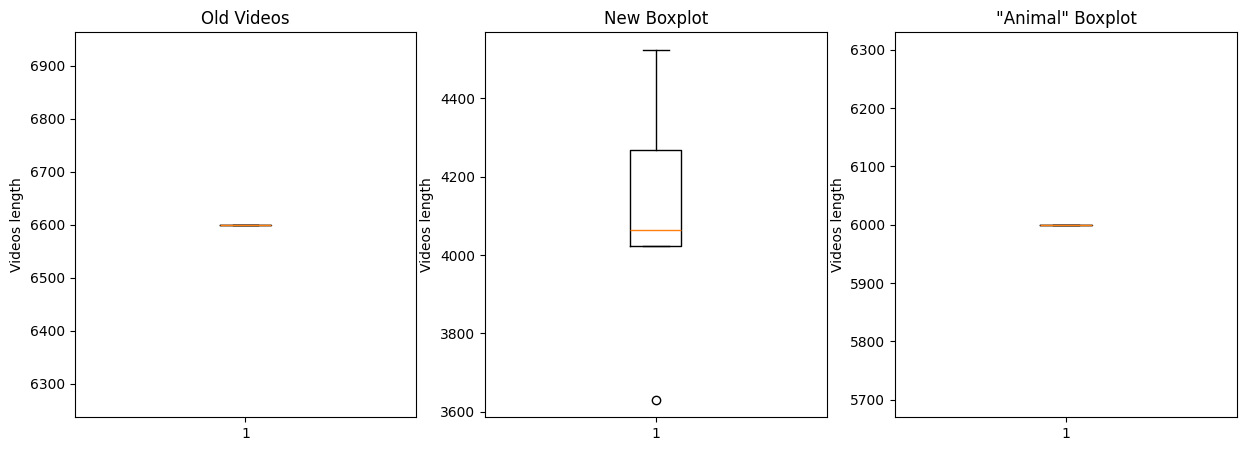

In [6]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(1,3, figsize=(15, 5))
axes[0].boxplot(duration_dict['old_vid'])
axes[0].set_title('Old Videos')
axes[0].set_xlabel('')
axes[0].set_ylabel('Videos length')

axes[1].boxplot(duration_dict['new_vid'])
axes[1].set_title('New Boxplot')
axes[1].set_xlabel('')
axes[1].set_ylabel('Videos length')

axes[2].boxplot(duration_dict['animal_vid'])
axes[2].set_title('"Animal" Boxplot')
axes[2].set_xlabel('')
axes[2].set_ylabel('Videos length')

plt.show()

We can also check the total number of frames for each subgroup.

In [7]:
print('Old video number of frames: ', sum(duration_dict['old_vid']))
print('New video number of frames: ', sum(duration_dict['new_vid']))
print('"Animal" video number of frames: ', sum(duration_dict['animal_vid']))

Old video number of frames:  112200
New video number of frames:  20507
"Animal" video number of frames:  12000


As we can see there is a considerable imbalance between the data on the 3 video classes. To solve this, we would create balanced splits and a DataGenerator that while training adjusts the probabilities of getting a sequence of each kifn of video. 

Before continiuing witht the procedure explanation. We would like to note that we have addopted the following terminology:

    . Train set = data set used on training to adjusts model's parameters
    . Test set = data set used on training on the Checkpoints to save model's best performance
    . Validation set =  data never seen while training, with the purpose of performing benchmarking between models

Since "Animal" type is the one with less frames and are only 2 videos, we will put one of them on validation dataset and the other one on the train set. That way we would be able to check if our models ad data are enough to generalize.

"New videos" type is the second category with less frames. There are 5 videos of this kind. We will save one (the shortest) for the validation set, another for the training set and 3 of them for training. The videos onthe train set will be the longest ones. To ensure we won't get data imbalance during training we would use a DataGenerator tjhat gives  ahigher probability for "new videos" sequences to be chooesed. To avoid overfitting, we will select aleatory sequences, that way each time they will be msotly different from the previous ones. 

Lastly, "Old videos" are the most common ones. We will save one video of this kind for the validation set. We will then perform a 70-30 split for the train and tests sets.

## Perform split

In [13]:
from sklearn.model_selection import train_test_split
import random

train = []
test = []
val = []

# First we will save the Animal type of videos
test.append(vid_dict['animal_vid'][0].split('.')[0])
val.append(vid_dict['animal_vid'][1].split('.')[0])

# We will then save the shortest New video in validation
val.append(vid_dict['new_vid'][np.argmin(duration_dict['new_vid'])].split('.')[0])
# We will save the second shortest on test
test.append(vid_dict['new_vid'][np.argsort(duration_dict['new_vid'])[1]].split('.')[0])
# And the 3rd largest on train
for i in np.argsort(duration_dict['new_vid'])[-3:]:
    train.append(vid_dict['new_vid'][i].split('.')[0])

# We will save the last Old video on validation
val.append(vid_dict['old_vid'][-1].split('.')[0])
# And perform a random split on the rest of them
random.seed(10) 
tr, ts = train_test_split(vid_dict['old_vid'], test_size=0.2, random_state=1)
for i in range(len(tr)):
    tr[i] = tr[i].split('.')[0]
for i in range(len(ts)):
    ts[i] = ts[i].split('.')[0]
    
train += tr
test += ts

print('Train set: ', train)
print('Test set: ', test)
print('Validation set: ', val)

Train set:  ['5', '3', '4', 'WT_ChR2_087A', 'WT_ChR2_654A', 'HD_YFP_443A', 'HD_ChR2_510A', 'WT_YFP_602A', 'HD_ChR2_480A', 'WT_YFP_792', 'WT_YFP_741A', 'WT_ChR2_635A', 'WT_ChR2_425A', 'WT_YFP_435A', 'WT_YFP_154A', 'HD_YFP_463A']
Test set:  ['Animal61980', '2', 'HD_YFP_037A', 'WT_YFP_535A', 'WT_ChR2_400A', 'HD_ChR2_586A']
Validation set:  ['Animal62418', '1', 'WT_YFP_792']


## Store the split

In [15]:
# Create a destination folder to store the data
dataset_path = '../data/processed/'
os.mkdir(dataset_path)

In [17]:
set_list = []

for i in features:
    if i in val:
        set_list.append('validation')
    elif i in test:
        set_list.append('test')
    else:
        set_list.append('train')

print(set_list)

['validation', 'test', 'train', 'train', 'train', 'test', 'validation', 'train', 'train', 'test', 'test', 'train', 'train', 'train', 'test', 'train', 'train', 'train', 'train', 'train', 'test', 'train', 'train', 'validation']


In [18]:
dataset_split = pd.DataFrame({
    'name': features,
    'set': set_list
})
dataset_split.to_csv(os.path.join(dataset_path, 'split.csv'), index=None)